### Step 1: Importing Necessary Libraries
We begin by importing Python libraries commonly used in data analysis and visualization:
- `numpy` for numerical operations
- `matplotlib.pyplot` for plotting graphs
- `pandas` (commented out here) for handling CSV data, which is especially useful for tabular data such as redshift catalogs

> Tip: If you haven’t used `pandas` before, it’s worth learning as it offers powerful tools to manipulate and analyze structured datasets.


For reading big csv files, one can use numpy as well as something called "pandas". We suggest to read pandas for CSV file reading and use that

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G, c
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u


Before we begin calculations, we define key physical constants used throughout:

- $ H_0 $: Hubble constant, describes the expansion rate of the Universe.
- $c$ : Speed of light.
-  $G$: Gravitational constant.
- $q_0$ : Deceleration parameter, used for approximate co-moving distance calculations.

We will use **`astropy.constants`** to ensure unit consistency and precision.

In [38]:
# Constants:
# Cosmological constant H0 in SI units (s^-1)
H_0 = cosmo.H0.to(1 / u.s).value # Hubble constant in SI
c = c.to('m/s').value # Speed of light in m/s
G = G.to('m3 / (kg s2)').value # Gravitational constant in pc kg^-1 (m/s)^2
q0=-0.534  # Deceleration parameter (assumed from Planck fit keep it as it is)

Read the csv data into the python using the method below

In [39]:
df = pd.read_csv('C:\AP_Personal\sci_comm\ISA\projects\Dynamical_mass\Skyserver_SQL4_26_2024 5_37_50_AM.csv', header=0,comment="#") 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      139 non-null    int64  
 1   ra         139 non-null    float64
 2   dec        139 non-null    float64
 3   photoz     139 non-null    float64
 4   photozerr  139 non-null    float64
 5   specz      139 non-null    float64
 6   speczerr   139 non-null    float64
 7   proj_sep   139 non-null    float64
 8   umag       139 non-null    float64
 9   umagerr    139 non-null    float64
 10  gmag       139 non-null    float64
 11  gmagerr    139 non-null    float64
 12  rmag       139 non-null    float64
 13  rmagerr    139 non-null    float64
 14  obj_type   139 non-null    int64  
dtypes: float64(13), int64(2)
memory usage: 16.4 KB


Explore the data in the excel as well to visualize the values

Do you find multple observations with same object ID? Object ID indicates the unique sky object. So you must group the data based on object ID

In [40]:
# Calculating the average specz for each id:
averaged_df = df.groupby('objid').agg({'specz': 'mean','ra': 'first','dec': 'first','proj_sep': 'first',}).reset_index()
averaged_df.describe()['specz']

count    92.000000
mean      0.080838
std       0.008578
min       0.069976
25%       0.077224
50%       0.080961
75%       0.082797
max       0.150886
Name: specz, dtype: float64

To create a cut in the redshift so that a cluster can be identified. We must use some logic. Most astronomers prefer anything beyond 3*sigma away from the mean to be not part of the same group. 

Find the mean, standard deviation and limits of the redshift from the data

In [41]:
averaged_df['specz'].mean(),3*averaged_df['specz'].std(), averaged_df['specz'].mean()+3*averaged_df['specz'].std()

(0.08083762565217394, 0.0257328417489049, 0.10657046740107884)

You can also use boxplot to visualize the overall values of redshift 

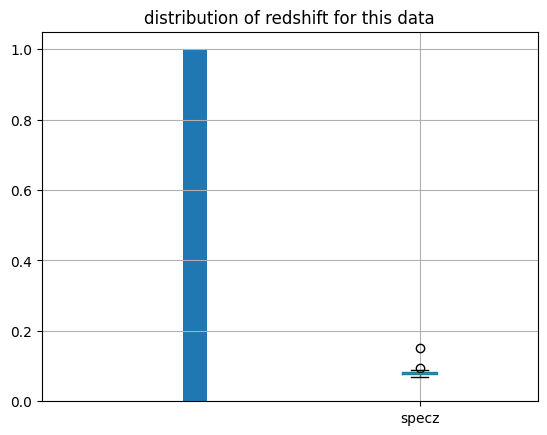

In [42]:
averaged_df.boxplot(column='specz')
plt.title("distribution of redshift for this data")
plt.show()

But the best plot would be a histogram to see where most of the objects downloaded lie in terms of redshift value

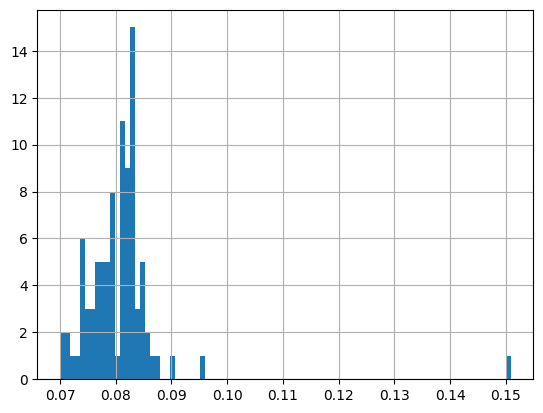

In [43]:
plt.hist(averaged_df['specz'],bins=90)
plt.grid()
plt.show()

Filter your data based on the 3-sigma limit of redshift. You should remove all data points which are 3-sigma away from mean of redshift

In [44]:
# Filtering the data based on specz values, used 3 sigma deviation from mean as upper limit.
filtered_df = averaged_df[(averaged_df['specz'] >= 0.06) & 
(averaged_df['specz'] <= averaged_df['specz'].mean()+3*averaged_df['specz'].std())]

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 0 to 91
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   objid     91 non-null     int64  
 1   specz     91 non-null     float64
 2   ra        91 non-null     float64
 3   dec       91 non-null     float64
 4   proj_sep  91 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 4.3 KB


Use the relation between redshift and velocity to add a column named velocity in the data. This would tell the expansion velocity at that redshift 

In [45]:
filtered_df.loc[:,'velocity'] = filtered_df['specz'] * c
filtered_df.head(2)

C:\Users\Aniket Prasad\AppData\Local\Temp\ipykernel_19260\87856802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:,'velocity'] = filtered_df['specz'] * c


,objid,specz,ra,dec,proj_sep,velocity
0,1237671768542478711,0.082457,257.82458,64.133257,8.347733,2.471993e+07
1,1237671768542478713,0.081218,257.83332,64.126043,8.011259,2.434867e+07


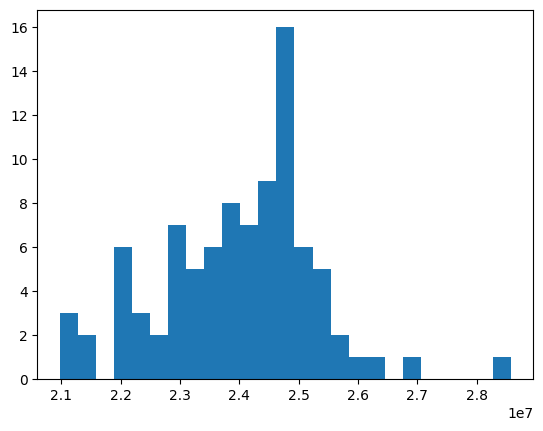

In [46]:
plt.hist(filtered_df['velocity'],bins=25)
plt.show()

use the dispersion equation to find something called velocity dispersion. You can even refer to wikipedia to know about the term [wiki link here](https://en.wikipedia.org/wiki/Velocity_dispersion#:~:text=In%20astronomy%2C%20the%20velocity%20dispersion,%2C%20galaxy%20cluster%2C%20or%20supercluster.)

It is the velocity dispersion value which tells us, some galaxies might be part of even larger groups!!

### Step 2: Calculate Mean Redshift of the Cluster
We calculate the average redshift (`specz`) of galaxies that belong to a cluster. This gives us an estimate of the cluster's systemic redshift.

`cluster_redshift = filtered_df['specz'].mean()`


The velocity dispersion \( v \) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula:

$$
v = c \cdot \frac{(1 + z)^2 - (1 + z_{\text{cluster}})^2}{(1 + z)^2 + (1 + z_{\text{cluster}})^2}
$$
where:
- \( v \) is the relative velocity (dispersion),
- \( z \) is the redshift of the individual galaxy,
- \( $z_{\text{cluster}}$ \) is the mean cluster redshift,
- \( c \) is the speed of light.


In [47]:
# Mean Redshift:
cluster_redshift = filtered_df['specz'].mean()
# Converting redshift to velocity dispersion of individual galaxies within cluster:
filtered_df.loc[:,'dispersion'] = (((1 + filtered_df['specz'])**2 - (1 + cluster_redshift)**2)/((1 + filtered_df['specz'])**2 
+(1+cluster_redshift)**2)) * c

C:\Users\Aniket Prasad\AppData\Local\Temp\ipykernel_19260\3089618654.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:,'dispersion'] = (((1 + filtered_df['specz'])**2 - (1 + cluster_redshift)**2)/((1 + filtered_df['specz'])**2


Pro tip: Check what the describe function of pandas does. Does it help to get quick look stats for your column of dispersion??

In [48]:
filtered_df.describe()['dispersion']

count    9.100000e+01
mean    -2.449331e+03
std      1.218493e+06
min     -2.814231e+06
25%     -8.066068e+05
50%      2.371791e+05
75%      7.549776e+05
max      4.206137e+06
Name: dispersion, dtype: float64

In [49]:
disp = ( ((filtered_df['dispersion'])**2).mean() )**0.5
print(f"The value of the cluster redshift = {cluster_redshift:.4}")
print(f"The characteristic value of velocity dispersion of the cluster along the line of sight = {disp:.4} km/s.")

The value of the cluster redshift = 0.08007
The characteristic value of velocity dispersion of the cluster along the line of sight = 1.212e+06 km/s.


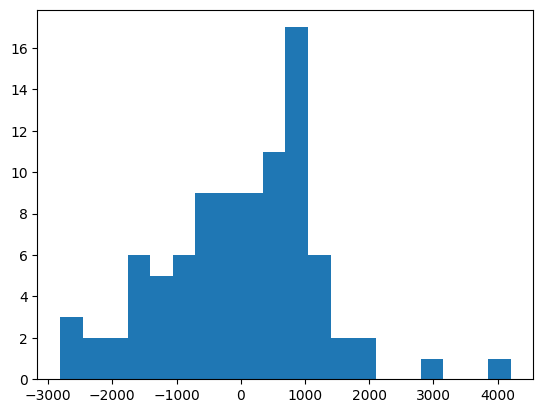

In [53]:
plt.hist(filtered_df['dispersion']/1000,bins=20)
plt.show()

In [54]:
df.describe()['proj_sep']

count    139.000000
mean       6.079801
std        2.517581
min        0.429175
25%        4.045745
50%        6.405518
75%        8.347733
max        9.844519
Name: proj_sep, dtype: float64

### Step 4: Visualizing Angular Separation of Galaxies
We plot a histogram of the projected (angular) separation of galaxies from the cluster center. This helps us understand the spatial distribution of galaxies within the cluster field.

- The x-axis represents the angular separation (in arcminutes or degrees, depending on units).
- The y-axis shows the number of galaxies at each separation bin.



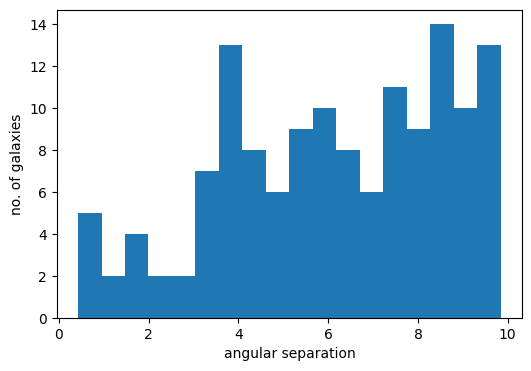

In [29]:
plt.figure(figsize=(6,4))
plt.hist(df['proj_sep'],bins=18)
plt.ylabel("no. of galaxies")
plt.xlabel("angular separation")
plt.show()

### Determining size and mass of the cluster:

### Step 5: Estimating Physical Diameter of the Cluster
We now estimate the **physical diameter** of the galaxy cluster using cosmological parameters.

- `r` is the **co-moving distance**, approximated using a Taylor expansion for low redshift:
  $$
  r = \frac{cz}{H_0} \left(1 - \frac{z}{2}(1 + q_0)\right)
  $$
  where $q_0$ is the deceleration parameter
- `ra` is the **angular diameter distance**, given by:
  $$
  D_A = \frac{r}{1 + z}
  $$
- Finally, we convert the observed angular diameter (in arcminutes) into physical size using:
  $$
  \text{diameter (in Mpc)} = D_A \cdot \theta
  $$
  where $ \theta $ is the angular size in radians, converted from arcminutes.

> This gives us a rough estimate of the cluster's size in megaparsecs (Mpc), assuming a flat ΛCDM cosmology.


In [55]:
r=c*(cluster_redshift/H_0)*(1-(cluster_redshift/2)*(1+q0))
ra=r/(1+cluster_redshift)
diameter=ra*((9.415/60)*(np.pi/180))/(3.086e22)
diameter #in Mpc

0.8827105529067586

### Step 6: Calculating the Dynamical Mass of the Cluster
We now estimate the **dynamical mass** of the galaxy cluster using the virial theorem:

$$
M_{\text{dyn}} = \frac{3 \sigma^2 R}{G}
$$

Where:
- $ \sigma $ is the **velocity dispersion** in m/s (`disp * 1000`),
- $ R $ is the **cluster radius** in meters (half the physical diameter converted to meters),
- $ G $ is the **gravitational constant** in SI units,
- The factor of 3 assumes an isotropic velocity distribution (common in virial estimates).

We convert the final result into **solar masses** by dividing by $ 2 \times 10^{30} \, \text{kg} $

> This mass estimate assumes the cluster is in dynamical equilibrium and bound by gravity.


In [56]:
### Calculating the dynamical mass in solar masses:
M_dyn =3*((disp)**2)*(diameter*0.5*10**6*3*10**16)/(G*2*10**30)

print(f"Dynamical Mass of the cluster is {M_dyn:.2e} solar mass")

Dynamical Mass of the cluster is 4.37e+14 solar mass


We dont need to code exactly for comparision. 

The luminous mass needs no calculation as such at this point. We can assume that the cluster is formed by milky-way like galaxies with 92 in number.

We know milky way's luminous mass is $10^{11}~\rm{M_{sun}}$. If cluster has say 100 members like this, the total luminous mass will be of the order of $10^{13}~\rm{M_{sun}}$ which is still 10 times less than the dynamical mass computed. 

This hidden matter which causes more gravity but no light is what constitutes the dark matter and dark energy part of such large scale cosmological structures.

Another method that can be used is to code for the luminosity and assume a mass to light ratio

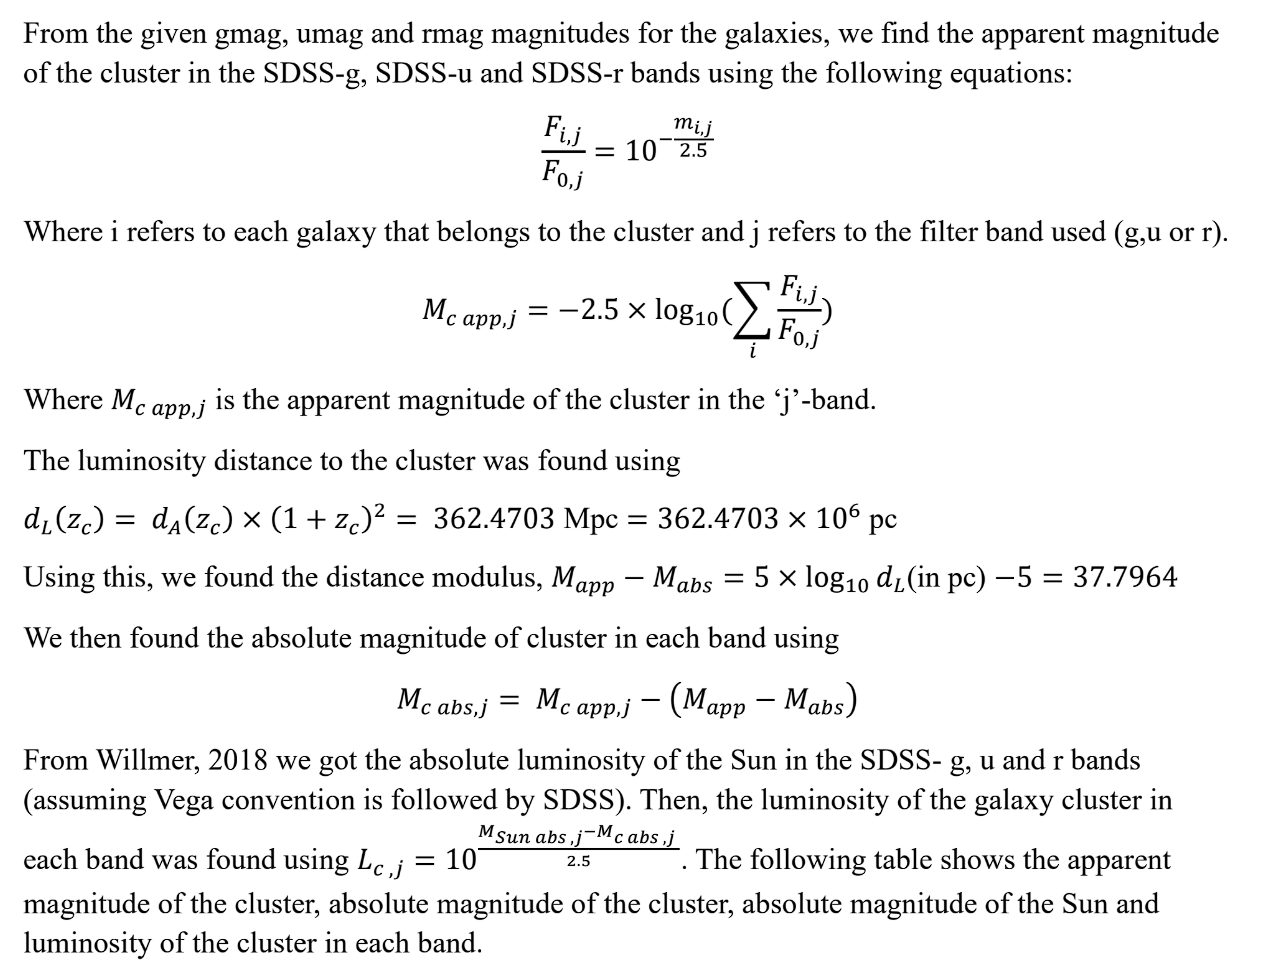

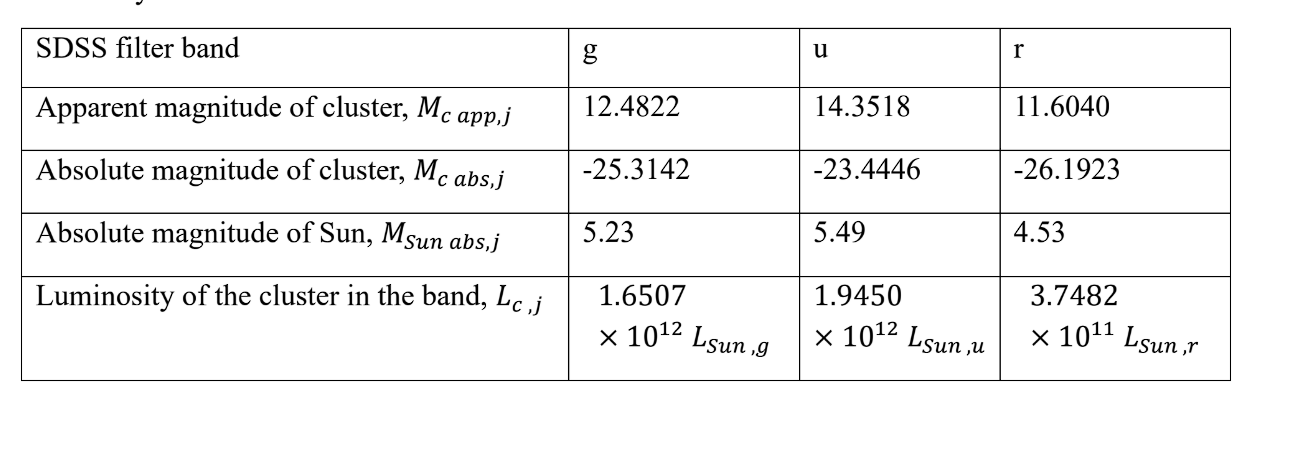

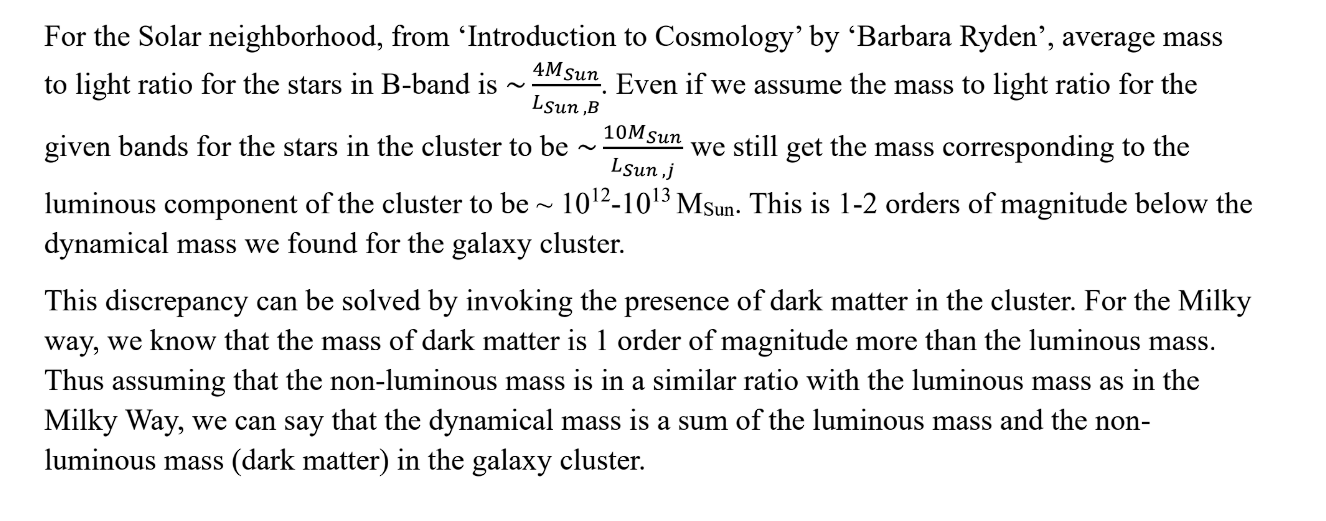

In [70]:
#Since luminous mass needed some idea about other terminology of astronomy, I intended to only let you guess luminous mass like i did above. 

#If you intend to calculate luminosity and assume a Mass to light ratio, i have shared answer above